In [12]:
import cv2, numpy as np
import matplotlib.pyplot as plt
from scipy import (signal, ndimage)
k_shape = (5,5)
ker_rct = cv2.getStructuringElement(cv2.MORPH_RECT      ,k_shape)
ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE   ,k_shape)
ker_crs = cv2.getStructuringElement(cv2.MORPH_CROSS     ,k_shape)
print(ker_rct,ker_ell,ker_crs, sep='\n\n')

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]

[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [13]:
ker_ellipse = lambda ks: cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks,ks))

# Detecting horizontal and vertical lines used morphological opening
### Prepare image

(-0.5, 2507.5, 1470.5, -0.5)

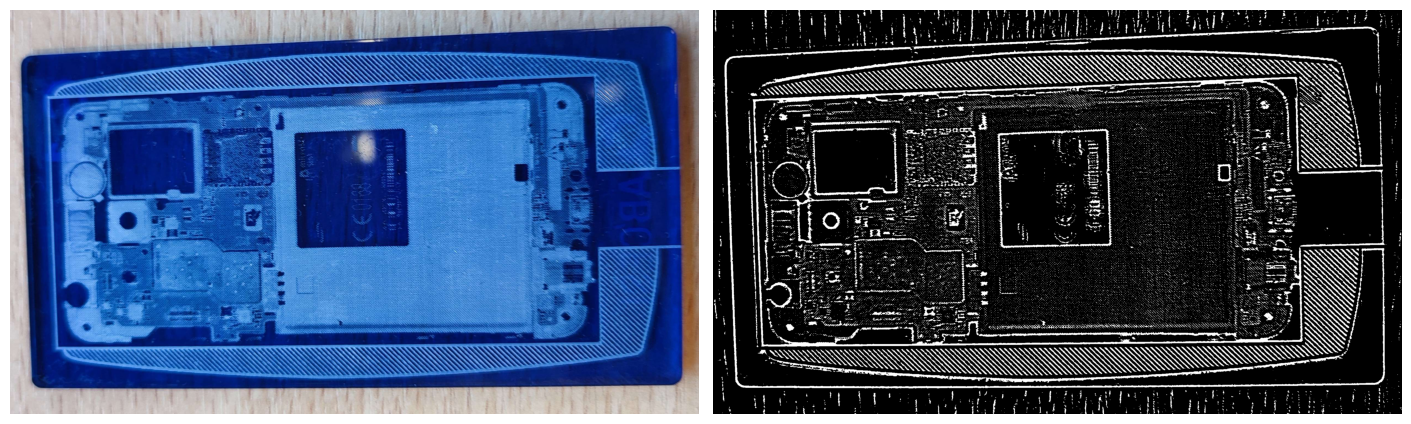

In [14]:
lnk = r'../media/phone.jpg'
img_rgb = cv2.cvtColor(cv2.imread(lnk, 1), cv2.COLOR_BGR2RGB)
img_rgb = np.rot90(img_rgb)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

k_size = 3
img_blur = img_gray#cv2.GaussianBlur(img_gray, (k_size,k_size), 0)
thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 7)

k_size2 = 3
erode = cv2.erode(thresh, ker_ellipse(k_size2),iterations=1)
img_gray_rgb = cv2.cvtColor(erode, cv2.COLOR_GRAY2RGB)
fig, ax = plt.subplots(1, 2, figsize=(14, 8), layout="constrained")
ax[0].imshow(img_rgb)
ax[0].axis('off')
ax[1].imshow(img_gray_rgb)
ax[1].axis('off')


### Apply a vertical and horizontal line detection kernels

(-0.5, 2507.5, 1470.5, -0.5)

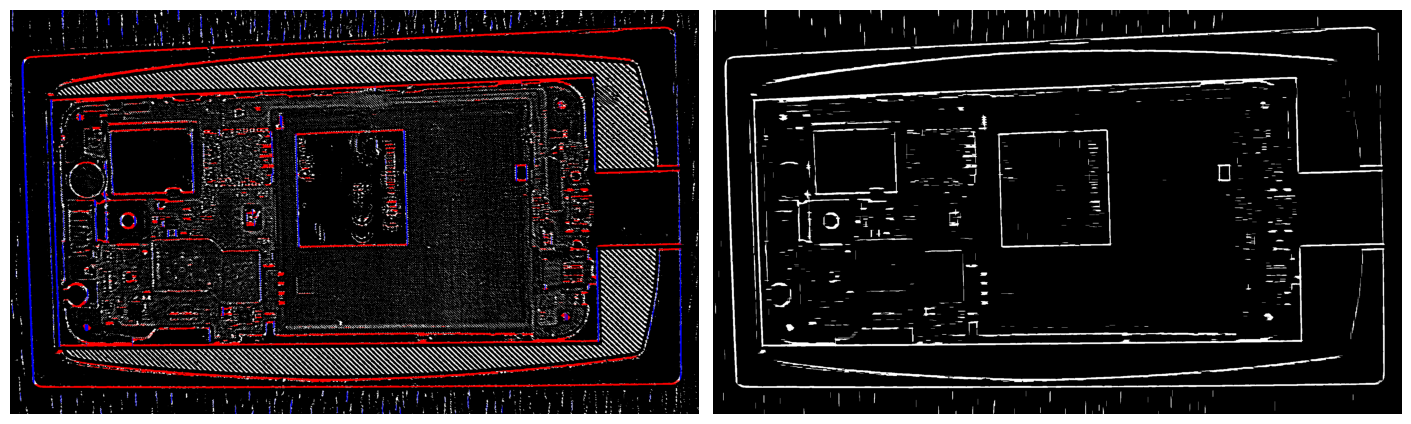

In [15]:
line_len_vert = 13
ker_vert = np.ones((1,line_len_vert))
line_vert_mask = cv2.morphologyEx(erode, cv2.MORPH_OPEN, ker_vert)

line_len_hor = 20
ker_hor = np.ones((line_len_hor,1))
line_hor_mask = cv2.morphologyEx(erode, cv2.MORPH_OPEN, ker_hor)

hor_vert = cv2.bitwise_or(line_vert_mask,line_hor_mask)
out_lines = img_gray_rgb.copy()
out_lines[line_vert_mask == 255] = [255,0,0]
out_lines[line_hor_mask == 255] = [0,0,255]

fig, ax = plt.subplots(1, 2, figsize=(14, 8), layout="constrained")
ax[0].imshow(out_lines)
ax[0].axis('off')
ax[1].imshow(hor_vert, 'gray')
ax[1].axis('off')

### Detect diagonal lines by applying diagonal kernel.
Technically you can create diagonal kernel with any angle.

(-0.5, 2507.5, 1470.5, -0.5)

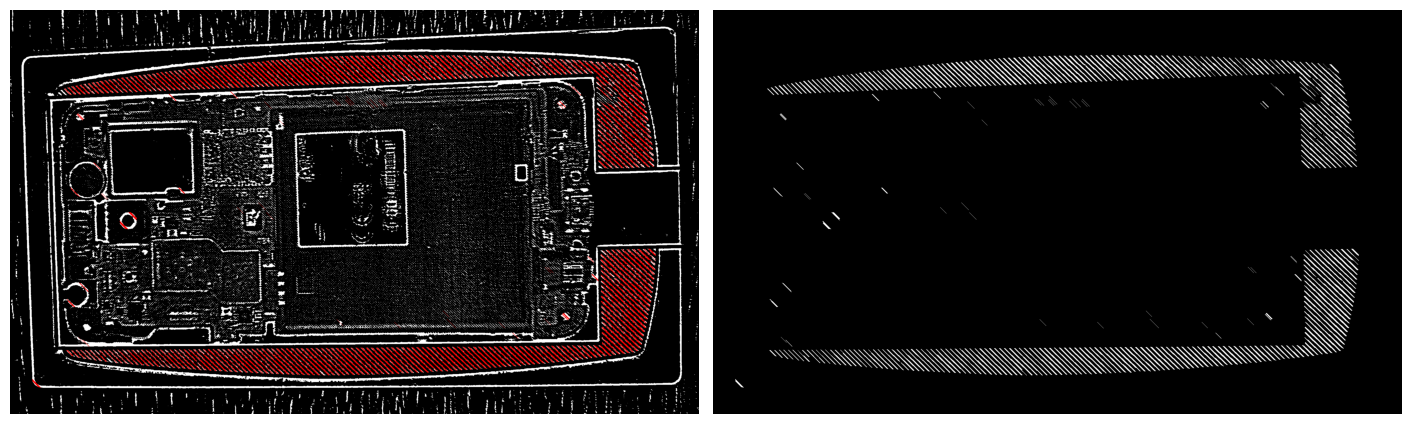

In [16]:
#ker_diag = ndimage.rotate(np.eye(20), angle=45, reshape=True, output=None, order=1, mode='constant', cval=0.0, prefilter=True)
ker_diag_len = 30
ker_diag = np.eye(int(ker_diag_len/np.sqrt(2)), dtype=np.uint8)
line_diag_mask = cv2.morphologyEx(erode, cv2.MORPH_OPEN, ker_diag)

out_lines = img_gray_rgb.copy()
out_lines[line_diag_mask == 255] = [255,0,0]

fig, ax = plt.subplots(1, 2, figsize=(14, 8), layout="constrained")
ax[0].imshow(out_lines)
ax[0].axis('off')
ax[1].imshow(line_diag_mask, 'gray')
ax[1].axis('off')

### Other option is to rotate image itself by an angle and apply line detection there
I have more success with image rotation rather than kernel rotation. Latter gets diffused.

(-0.5, 2813.5, 2813.5, -0.5)

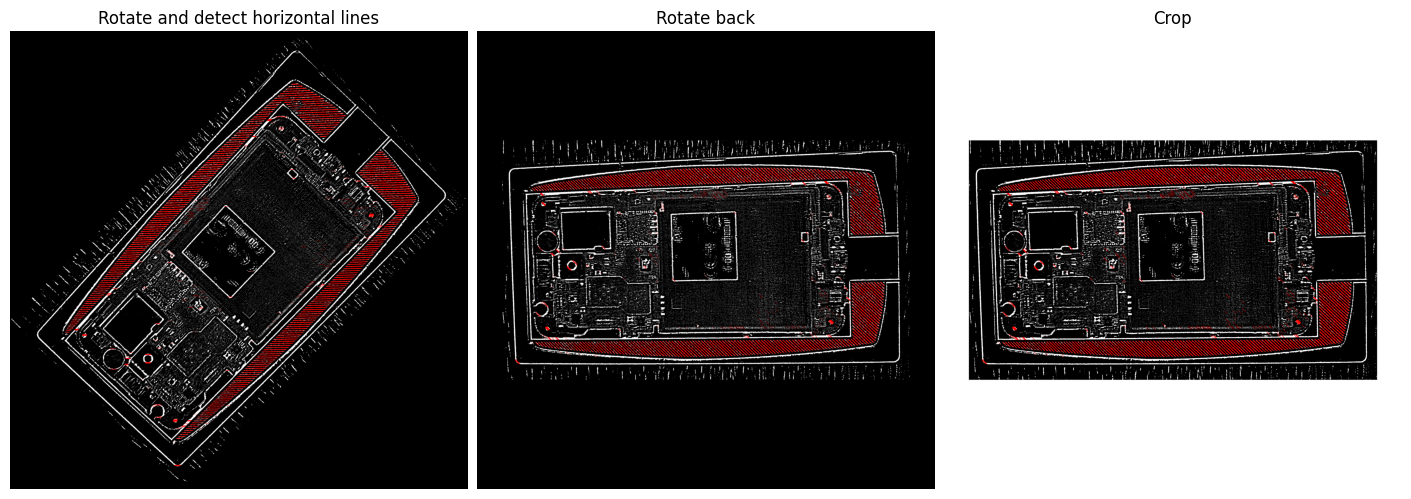

In [17]:
H,W = erode.shape
order = 3
angle = 45
erode_rot = ndimage.rotate(erode, angle=angle, reshape=True, output=None, order=order, mode='constant', cval=0.0, prefilter=True)
CY,CX = np.array(erode_rot.shape, int)//2

line_len_vert = 23
ker_vert = np.ones((1,line_len_vert))
rotated_mask = cv2.morphologyEx(erode_rot, cv2.MORPH_OPEN, ker_vert)
rotated_mask = cv2.threshold(rotated_mask, 50, 255, cv2.THRESH_BINARY)[1]
# take half-widths of image, 
# in case of odd dimension, take left half even, right odd.
H1,W1 = H//2, W//2
H2, W2 = H - H1, W - W1

mask_big = ndimage.rotate(rotated_mask, angle=-angle, reshape=False, output=None, order=order, mode='constant', cval=0.0, prefilter=True)
mask = mask_big[CY-H1:CY+H2,CX-W1:CX+W2]
mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)[1]


out_lines = img_gray_rgb.copy()
out_lines[mask == 255] = [255,0,0]

# for drawing rotate rgb versions

erode_rot_m = cv2.cvtColor(erode_rot, cv2.COLOR_GRAY2RGB)
erode_rot_m[rotated_mask == 255] = [255,0,0]

erode_rot_m_rot = ndimage.rotate(erode_rot_m, angle=-angle, reshape=False, output=None, order=order, mode='constant', cval=0.0, prefilter=True)

blank = np.ones_like(erode_rot_m, np.uint8)*255 # placed on a white blank so title is on the same level as others.
blank[CY-H1:CY+H2,CX-W1:CX+W2] = out_lines

fig, ax = plt.subplots(1, 3, figsize=(14, 8), layout="constrained")
ax[0].imshow(erode_rot_m)
ax[0].set_title('Rotate and detect horizontal lines')
ax[0].axis('off')
ax[1].imshow(erode_rot_m_rot)
ax[1].set_title('Rotate back')
ax[1].axis('off')
ax[2].imshow(blank)
ax[2].set_title('Crop')
ax[2].axis('off')

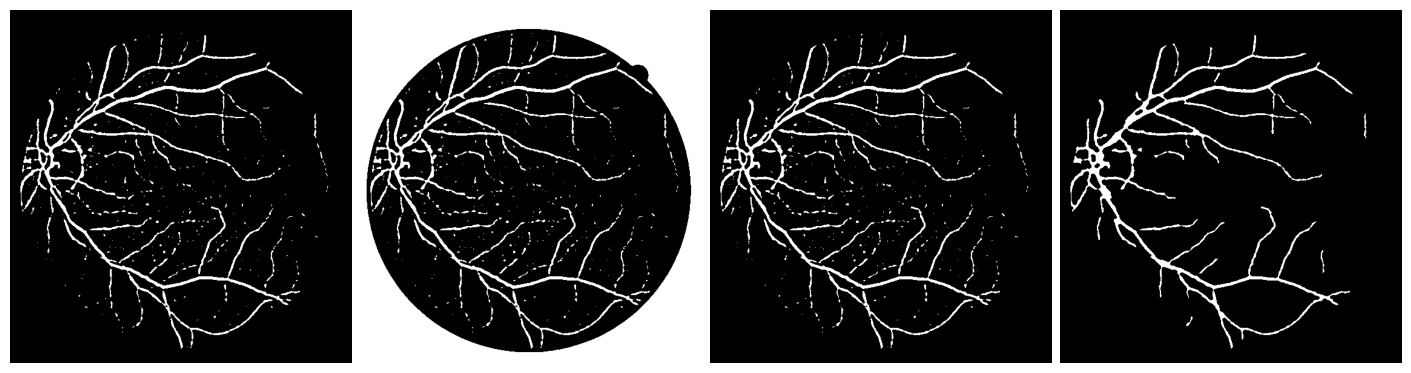

In [18]:
import numpy as np
import cv2

fig, ax = plt.subplots(1, 4, figsize=(14, 8), layout="constrained")
lnk = r'../media/vessel.png'
img = cv2.imread(lnk, 0)

# PRE_PROCESSING
k_size = 7
img_blur = cv2.GaussianBlur(img, (k_size,k_size), 0)

thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
imgs = [thresh]
cv2.floodFill(thresh, None, (0,0), 255)
imgs.append(thresh.copy())
cv2.floodFill(thresh, None, (0,0), 0)

# STUFF STARTS HERE
k_size2 = 3

ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size2,k_size2))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, ker_ell)

imgs.append(thresh.copy())

contours, _ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 20
contours_filtered = [c for c in contours if cv2.contourArea(c) > min_contour_area]

blank = np.zeros_like(img, dtype=np.uint8)
cv2.drawContours(blank, contours_filtered, -1, 255, -1)

k_size3 = 7
ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size3,k_size3))
blank = cv2.morphologyEx(blank, cv2.MORPH_CLOSE, ker_ell)

imgs.append(blank)
for i,im in enumerate(imgs):
    ax[i].imshow(im, 'gray')
    ax[i].axis('off')
plt.show()

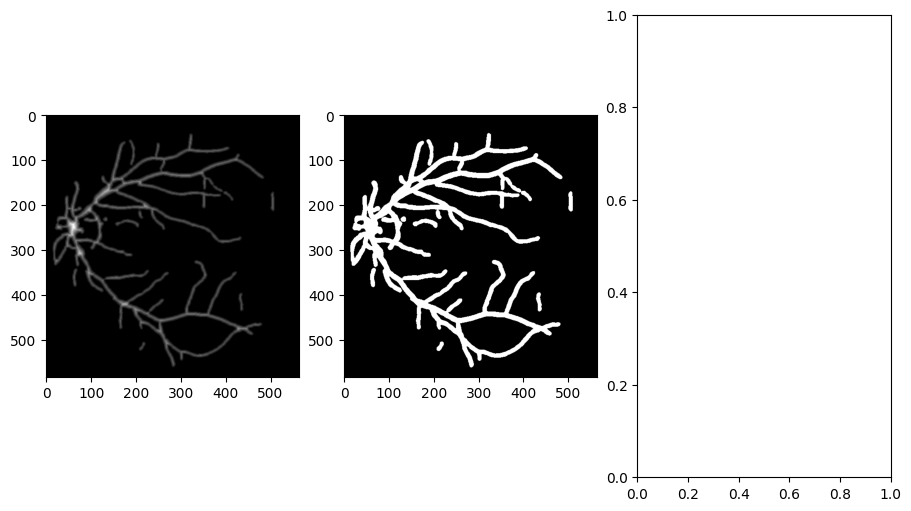

In [19]:
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_cdt
fig, ax = plt.subplots(1, 3, figsize=(9, 5), layout="constrained")

k_size = 11
blank2 = cv2.GaussianBlur(blank, (k_size,k_size), 0)

thld0 = np.uint8(blank2 > 10) * 255
dtr = distance_transform_cdt(thld0, metric="chessboard")

# skel = np.uint8(skeletonize(blank))
ax[0].imshow(dtr, 'gray')

thld = np.uint8(dtr > 0.1) * 255
# k_size2 = 11
# ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size2,k_size2))
# open1 = cv2.morphologyEx(skel, cv2.MORPH_CLOSE, ker_ell)
ax[1].imshow(thld, 'gray')

# skel2 = np.uint8(skeletonize(open1))

# ax[2].imshow(skel2, 'gray')


In [20]:
#00628627
#KGV36UW30/05
# img1 = cv2.imread(r'e:\relocated\Downloads\1.png',flags=cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(r'e:\relocated\Downloads\2.png',flags=cv2.IMREAD_GRAYSCALE)